In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
import re


# import os
# import sys
# sys.path.insert(0, "/home/nramachandra/Projects/Hydro_runs/Flamingo/Clean")


from cosmo_hydro_emu.pca import *
from cosmo_hydro_emu.viz import *
from cosmo_hydro_emu.load_hacc import *
from cosmo_hydro_emu.emu import *
from cosmo_hydro_emu.gp import *

# from hydro_emu.mcmc import *

# Load files -- all summary stats

In [2]:
# PARAM_NAME = [r'$f_{SN}$', r'$vel$',  r'$log(T_{AGN})$', r'$\beta_{BH}$']
# PARAM_NAME = [r'$f_{SN}$', r'log($vel$)',  r'$log(T_{AGN})$', r'$\beta_{BH}$', 'SEED'] ## 3A/3B
# PARAM_NAME = ['KAPPA', 'EGW', 'SEED', 'VKIN', 'EPS'] ## HACC-5p

# PARAM_NAME =  [r'$\kappa_w$', r'$e_w$', r'$\mathrm{m_{BH,seed}}/10^{6}$',
#      r'$v_\mathrm{kin}/10^{4}$', r'$\epsilon/10^{1}$']

In [3]:
PARAM_NAME

['$\\kappa_\\text{w}$',
 '$e_\\text{w}$',
 '$M_\\text{seed}/10^{6}$',
 '$v_\\text{kin}/10^{4}$',
 '$\\epsilon_\\text{kin}/10^{1}$']

In [4]:
DirIn = '../data/400MPC_RUNS_5SG_2COSMO_PARAM/HAvoCC/'

save_model = 'False'

start_sim_idx = 1
num_sims = 39
exp_variance = 0.95

if_plot_sensi = True

In [5]:
import os
import numpy as np
import re


# pattern = re.compile(r'FSN_(\d+\.\d+|10|0)_VEL_(\d+\.\d+)_TEXP_(\d+\.\d+|10|0)_BETA_(\d+\.\d+|0)_SEED_(\d+\.?\d*e[\+\-]?\d+)')
# Regular expression pattern
# pattern = re.compile(r'KAPPA_(\d+\.?\d*)_EGW_(\d+\.?\d*)_SEED_([\d\.eE\+\-]+)_VKIN_([\d\.]+)_EPS_([\d\.eE\+\-]+)')

# def read_params_from_files(pattern):
#     # List to store the extracted values
#     data = []
#     # Loop through each subdirectory name in the directory
#     for subdirectory_name in os.listdir(DirIn):
#         # print(f"Checking: {subdirectory_name}")
#         match = pattern.match(subdirectory_name)
#         if match:
#             # print(f"Matched: {subdirectory_name}")
#             data.append([float(match.group(1)), float(match.group(2)), float(match.group(3).replace('e', 'E')),
#                         float(match.group(4)), float(match.group(5).replace('e', 'E'))])
#         else:
#             print(f"No match: {subdirectory_name}")
#     # Convert the list to a numpy array
#     params_all = np.array(data)

    # return params_all

def read_params(fileIn):
    params_all = np.loadtxt(fileIn, delimiter=",", skiprows=1)
    start_sim_idx = 1
    end_sim_idx = 40
    print('Loaded file with params: ', params_all.shape)



    return params_all[start_sim_idx:end_sim_idx]
    # kappa_W,e_W,M_seed,v_kin,eps_kin,omega_m,sigma_8
    

fileIn = '/home/nramachandra/Projects/Hydro_runs/CosmoHydro/data/FinalDesign.txt'

params32 = read_params(fileIn)



seed_mass_scale = 1e6
vkin_scale = 1e4
eps_scale = 1e1

params32[:, 2] = params32[:, 2]/seed_mass_scale
params32[:, 3] = params32[:, 3]/vkin_scale
params32[:, 4] = params32[:, 4]/eps_scale

PARAM_NAME = ['$\\kappa_\\text{w}$',
                '$e_\\text{w}$',
                '$M_\\text{seed}/10^{6}$',
                '$v_\\text{kin}/10^{4}$',
                '$\\epsilon_\\text{kin}/10^{1}$', 
                '$\\omega_\\text{m}$',
                '$\\sigma_\\text{8}$'
                ]

Loaded file with params:  (110, 7)


In [6]:
params32.shape

(39, 7)

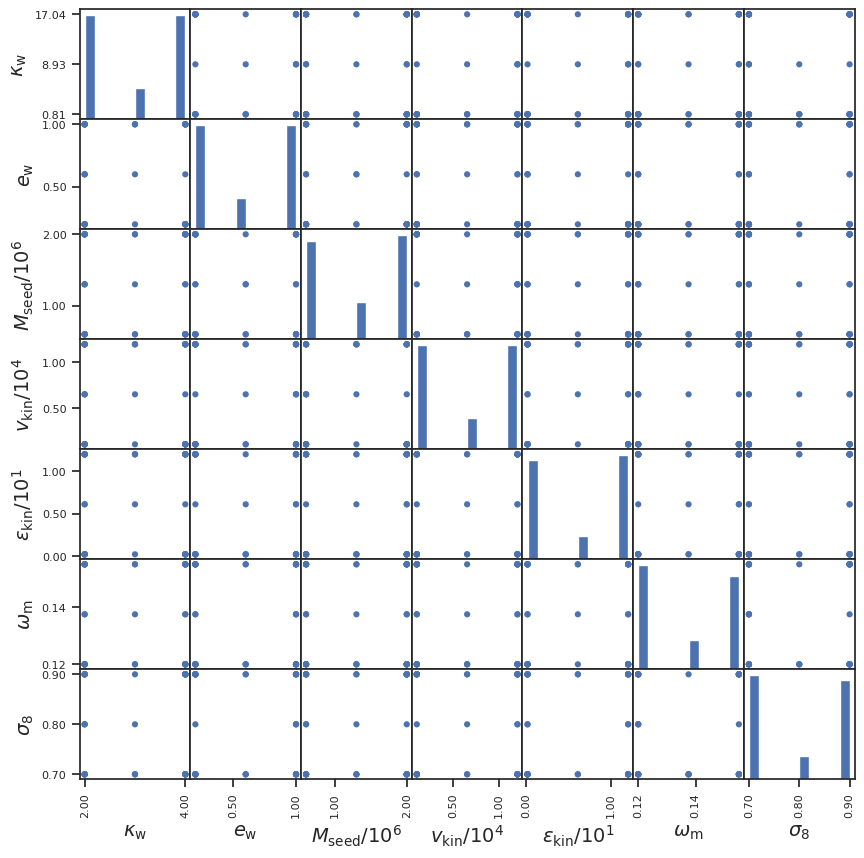

In [7]:
# Print the numpy array

        
df_train_a = pd.DataFrame(params32, columns=PARAM_NAME)
colors = ['b']*params32.shape[0]
# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);
plt.savefig('../plots/exp_design.png', bbox_inches='tight')

In [8]:
stellar_mass, gsmf_arr = read_gsmf(DirIn, num_sims, start_sim_idx=start_sim_idx)
# log_bhmsm_mass, bhmsm_arr = read_bhmsm(DirIn, num_sims, start_sim_idx=start_sim_idx)  # Not available in new dataset
# log_ssfr_mass, gal_ssfr_arr = read_gal_ssfr(DirIn, num_sims, start_sim_idx=start_sim_idx)  # Not available in new dataset
log_halo_mass, gas_fr_arr = read_gasfr(DirIn, num_sims, start_sim_idx=start_sim_idx)
radius, cged_arr = read_cged(DirIn, num_sims, start_sim_idx=start_sim_idx)
radius, cgd_arr = read_cgd(DirIn, num_sims, start_sim_idx=start_sim_idx)

# Visualize -- all summary stats with parameter dependence + obs data

In [9]:
# bhmsm_obs_dir = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/galaxy_modules/BHMass_StellarMass/data/'  # No BHMSM sim data
gsmf_obs_dir = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/galaxy_modules/GalStellarMassFunction/data/'
gasFr_obs_dir = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/halo_modules/Mgas_M500/data/'
cged_obs_dir = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/halo_profile_modules/ClusterGasElectronDensityProfile/data/'
cgd_obs_dir = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/halo_profile_modules/ClusterGasDensityProfile/data/'

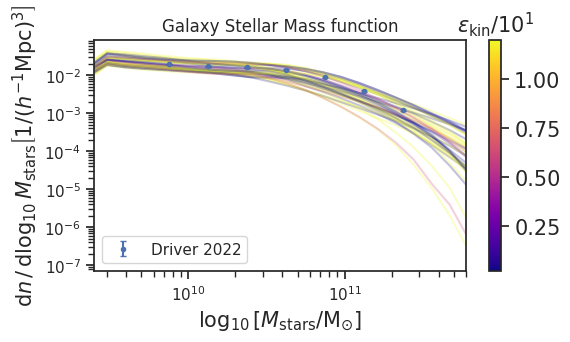

In [10]:
color_by_index = 4

plt_strings = plot_strings('GSMF')
mlim1, mlim2 = mass_conds('GSMF')

f, a = plt.subplots(1, 1, figsize=(6, 3))

x, y, yerr = load_gsmf_obs(gsmf_obs_dir)
mass_cond = np.where( (x > mlim1)  &  (x < mlim2) ) 
a.errorbar(x[mass_cond], y[mass_cond], yerr=yerr[:, mass_cond][:, 0, :], fmt=".b", capsize=2, label=r"Driver 2022")

f = plot_lines_with_param_color(params32[:, color_by_index], 
                            stellar_mass, 
                            gsmf_arr, 
                            *plt_strings,
                            PARAM_NAME[color_by_index], 
                            mlim1, 
                            mlim2,
                            a);

a.set_xlim(0.5*mlim1, 2*mlim2)
a.set_xscale('log')
a.set_yscale('log')
# a.legend(bbox_to_anchor=(2, 0.7))
a.legend()

plt.title('Galaxy Stellar Mass function')

plt.savefig('../plots/GSMF_design.png', bbox_inches='tight')

In [11]:
# BHMSM plot - commented out: BHMass_StellarMass data not available in new dataset
# plt_strings = plot_strings('BHMSM')
# mlim1, mlim2 = mass_conds('BHMSM')
# 
# mlim1 = 1e8
# 
# color_by_index = 0
# f, a = plt.subplots(1, 1, figsize=(6, 3))
# 
# 
# data = load_bhmsm_other_sims(bhmsm_obs_dir)
# 
# for sourceIn in data.keys():
#     print(sourceIn)
#     x_transformed, y = data[sourceIn]
#     a.plot(x_transformed, y, 'x-.', label=sourceIn)
# 
# 
# plot_lines_with_param_color(params32[:, color_by_index], 
#                             10**log_bhmsm_mass, 
#                             bhmsm_arr, 
#                             *plt_strings,
#                             PARAM_NAME[color_by_index], 
#                             mlim1, 
#                             mlim2, 
#                             a);
# 
# a.legend(bbox_to_anchor=(1.1, 1.5))
# a.set_xscale('log')
# a.set_yscale('log')
# a.set_xlim(1e9, 1e12)
# a.legend()
# 
# plt.title('Black-Hole Mass to Stellar Mass')
# 
# 
# plt.savefig('../plots/BHMSM_design.png', bbox_inches='tight')

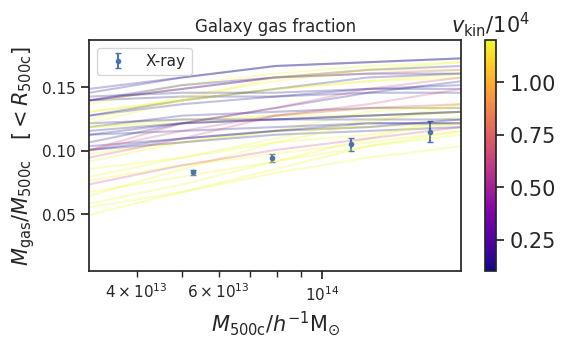

In [12]:
plt_strings = plot_strings('fGas')
mlim1, mlim2 = mass_conds('fGas')

f, a = plt.subplots(1, 1, figsize=(6, 3))
color_by_index = 3

x, y, yerr = load_fgas_obs()
a.errorbar( x, y, yerr, fmt=".b", capsize=2, label=r"X-ray")

'''
data = load_fgas_other_sims(gasFr_obs_dir)
for sourceIn in data.keys():
        x_transformed, y = data[sourceIn]
        a.plot(x_transformed, y, 'x-.', label=sourceIn)

'''

a.set_xscale('log')
# a.set_yscale('log')

f = plot_lines_with_param_color(params32[:, color_by_index], 
                            10**log_halo_mass, 
                            gas_fr_arr,
                            *plt_strings,
                            PARAM_NAME[color_by_index], 
                            mlim1, 
                            mlim2, 
                            a);

# a.legend(bbox_to_anchor=(1.4, 0.6))
a.legend()

plt.title('Galaxy gas fraction')

plt.savefig('../plots/fGas_design.png', bbox_inches='tight')

In [13]:
# gSSFR plot - commented out: GalaxySSFR data not available in new dataset
# plt_strings = plot_strings('gSSFR')
# mlim1, mlim2 = mass_conds('gSSFR')
# 
# f, a = plt.subplots(1, 1, figsize=(6, 3))
# 
# 
# f = plot_lines_with_param_color(params32[:, color_by_index], 
#                                 10**log_ssfr_mass, 
#                                 gal_ssfr_arr,
#                                 *plt_strings,
#                                 PARAM_NAME[color_by_index], 
#                                 mlim1, 
#                                 mlim2, 
#                                 a);

In [14]:


# # /home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/global_state.py


# RHO_C = 2.77536627e11  # Critical density in (M_sun/h) / (Mpc/h)^3
# MPC_IN_CM = 3.24077927e-25
# G_IN_MSUN = 1.9885e33
# MP = 1.67262158e-24  # Mass of proton in grams (using 1.00794 amu )


# _rhoc_cgs = RHO_C * 0.7**2  # in proper (Msun/h) / (Mpc/h)^3 = h^2 Msun/Mpc^3
# _rhoc_cgs *= MPC_IN_CM**3 * G_IN_MSUN

McDonald2017_med
McDonald2017_avg
Ghirardini2019
braspenning2023_rho_z0
lehle2023_rho_z0
mcdonald2017_avg
mcdonald2017_median
ghirardini2019_rho_z0


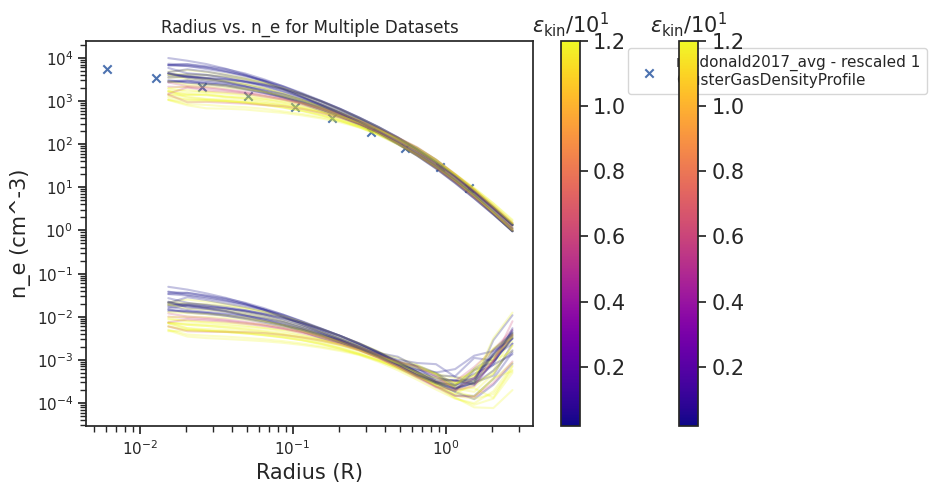

In [15]:
f, a = plt.subplots(1, 1, figsize=(9, 5))

color_by_index = 4

cged_obs_dir_old = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/halo_profile_modules/ClusterGasElectronDensityProfile/data/'

data = load_cged_obs(directory=cged_obs_dir_old)

for source, (radius_obs, ne_values) in data.items():
    print(source)
    
    if source == 'McDonald2013':
            # ne = 0
        
        # for i, ne in enumerate(ne_values.T):
        
            i = 0 
            ne = ne_values.T[i]
            a.scatter(radius_obs, ne, marker='x', label=f'{source} - n_e column {i+1}' + '\n' + 'ClusterGasElectronDensityProfile')
            
            # conversion used in McDonald2017: rhog = mp*ne*A/Z with A = 1.397, Z = 1.199
            # ne = ne*_rhoc_cgs / MP / 1.397 * 1.199
            # a.scatter(radius_obs, ne, marker='x', label=f'{source} - rescaled {i+1}')
 

cgd_obs_dir = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/halo_profile_modules/ClusterGasDensityProfile/data/'
data = load_cgd_obs(directory=cgd_obs_dir)


            
for source, (radius_obs, ne_values) in data.items():
    print(source)
    
    if source == 'mcdonald2017_avg':
            # ne = 0
        
        # for i, ne in enumerate(ne_values.T):
        
            i = 0 
            ne = ne_values.T[i]
            # a.scatter(radius_obs, ne, marker='x', label=f'{source} - n_e column {i+1}')
            
            # conversion used in McDonald2017: rhog = mp*ne*A/Z with A = 1.397, Z = 1.199
            # ne = ne*_rhoc_cgs / MP / 1.397 * 1.199
            a.scatter(radius_obs, ne, marker='x', label=f'{source} - rescaled {i+1}' + '\n' + 'ClusterGasDensityProfile')
            
            

f = plot_lines_with_param_color(params32[:, color_by_index], 
                                radius, 
                                cgd_arr,
                                *plt_strings,
                                PARAM_NAME[color_by_index], 
                                None, 
                                None, 
                                a);

f = plot_lines_with_param_color(params32[:, color_by_index], 
                                radius, 
                                cged_arr,
                                *plt_strings,
                                PARAM_NAME[color_by_index], 
                                None, 
                                None, 
                                a);

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (R)')
plt.ylabel('n_e (cm^-3)')
plt.title('Radius vs. n_e for Multiple Datasets')
plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1))
plt.show()

braspenning2023_rho_z0
lehle2023_rho_z0
mcdonald2017_avg
mcdonald2017_median
ghirardini2019_rho_z0


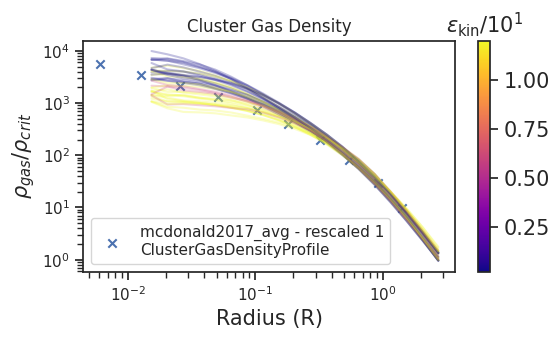

In [16]:
f, a = plt.subplots(1, 1, figsize=(6, 3))

 
cgd_obs_dir = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/halo_profile_modules/ClusterGasDensityProfile/data/'
data = load_cgd_obs(directory=cgd_obs_dir)

        
color_by_index = 4
for source, (radius_obs, ne_values) in data.items():
    print(source)
    
    if source == 'mcdonald2017_avg':
            # ne = 0
        
        # for i, ne in enumerate(ne_values.T):
        
            i = 0 
            ne = ne_values.T[i]
            # a.scatter(radius_obs, ne, marker='x', label=f'{source} - n_e column {i+1}')
            
            # conversion used in McDonald2017: rhog = mp*ne*A/Z with A = 1.397, Z = 1.199
            # ne = ne*_rhoc_cgs / MP / 1.397 * 1.199
            a.scatter(radius_obs, ne, marker='x', label=f'{source} - rescaled {i+1}' + '\n' + 'ClusterGasDensityProfile')
            
            

f = plot_lines_with_param_color(params32[:, color_by_index], 
                                radius, 
                                cgd_arr,
                                *plt_strings,
                                PARAM_NAME[color_by_index], 
                                None, 
                                None, 
                                a);


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (R)')
plt.ylabel(r'$\rho_{gas} / \rho_{crit}$')
plt.title('Cluster Gas Density')
# plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1))
plt.legend()

plt.savefig('../plots/CGD_design.png', bbox_inches='tight')

braspenning2023_rho_z0
lehle2023_rho_z0
mcdonald2017_avg
mcdonald2017_median
ghirardini2019_rho_z0


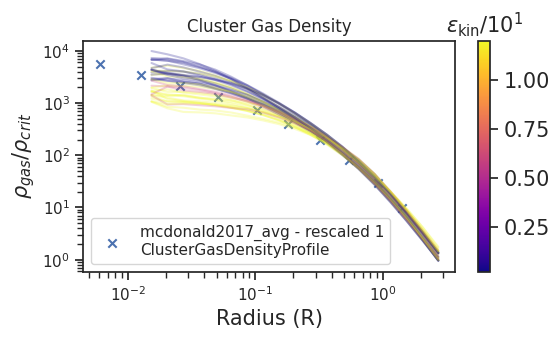

In [17]:
f, a = plt.subplots(1, 1, figsize=(6, 3))

 
cgd_obs_dir = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/halo_profile_modules/ClusterGasDensityProfile/data/'
data = load_cgd_obs(directory=cgd_obs_dir)

        
color_by_index = 4
for source, (radius_obs, ne_values) in data.items():
    print(source)
    
    if source == 'mcdonald2017_avg':
            # ne = 0
        
        # for i, ne in enumerate(ne_values.T):
        
            i = 0 
            ne = ne_values.T[i]
            # a.scatter(radius_obs, ne, marker='x', label=f'{source} - n_e column {i+1}')
            
            # conversion used in McDonald2017: rhog = mp*ne*A/Z with A = 1.397, Z = 1.199
            # ne = ne*_rhoc_cgs / MP / 1.397 * 1.199
            a.scatter(radius_obs, ne, marker='x', label=f'{source} - rescaled {i+1}' + '\n' + 'ClusterGasDensityProfile')
            
            

f = plot_lines_with_param_color(params32[:, color_by_index], 
                                radius, 
                                cgd_arr,
                                *plt_strings,
                                PARAM_NAME[color_by_index], 
                                None, 
                                None, 
                                a);


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (R)')
plt.ylabel(r'$\rho_{gas} / \rho_{crit}$')
plt.title('Cluster Gas Density')
# plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1))
plt.legend()

plt.savefig('../plots/CGD_design.png', bbox_inches='tight')

In [18]:
RHO_C = 2.77536627e11  # Critical density in (M_sun/h) / (Mpc/h)^3
MPC_IN_CM = 3.24077927e-25
G_IN_MSUN = 1.9885e33
MP = 1.67262158e-24  # Mass of proton in grams (using 1.00794 amu )


_rhoc_cgs = RHO_C * 0.7**2  # in proper (Msun/h) / (Mpc/h)^3 = h^2 Msun/Mpc^3
_rhoc_cgs *= MPC_IN_CM**3 * G_IN_MSUN

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


McDonald2017_med
McDonald2017_avg
Ghirardini2019


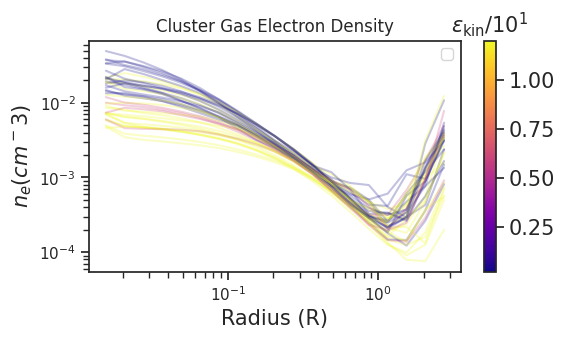

In [19]:
f, a = plt.subplots(1, 1, figsize=(6, 3))
color_by_index = 4

cged_obs_dir_old = '/home/nramachandra/Projects/Hydro_runs/HAvoCC/havocc/analysis/modules/halo_profile_modules/ClusterGasElectronDensityProfile/data/'

data = load_cged_obs(directory=cged_obs_dir_old, rho_cgs_scale=True)

for source, (radius_obs, ne_values) in data.items():
    print(source)
    
    if source == 'McDonald2013':
            # ne = 0
        
        # for i, ne in enumerate(ne_values.T):
        
            i = 0 
            ne = ne_values.T[i]
            a.scatter(radius_obs, ne, marker='x', label=f'{source} - n_e column {i+1}' + '\n' + 'ClusterGasElectronDensityProfile')
            
            # conversion used in McDonald2017: rhog = mp*ne*A/Z with A = 1.397, Z = 1.199
            # ne = ne*_rhoc_cgs / MP / 1.397 * 1.199
            # a.scatter(radius_obs, ne, marker='x', label=f'{source} - rescaled {i+1}')
 

f = plot_lines_with_param_color(params32[:, color_by_index], 
                                radius, 
                                cged_arr,
                                *plt_strings,
                                PARAM_NAME[color_by_index], 
                                None, 
                                None, 
                                a);

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (R)')
plt.ylabel(r'$n_e (cm^-3)$')
plt.title('Cluster Gas Electron Density')
# plt.legend(loc='upper right', bbox_to_anchor=(1.9, 1))
plt.legend()

plt.savefig('../plots/CGED_design.png', bbox_inches='tight')

# Emulate stat-1: GSMF

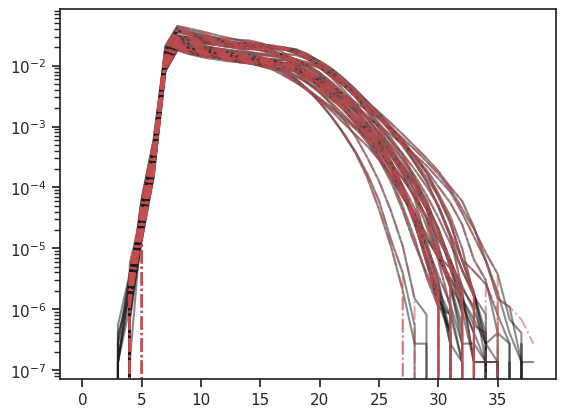

In [20]:
# Example usage with the original data
gsmf_arr_extra = fill_nan_with_interpolation(gsmf_arr, 'linear')

plt.plot(gsmf_arr.T, 'k', alpha=0.5);
plt.plot(gsmf_arr_extra.T, 'r-.', alpha=0.5);
plt.yscale('log')

1.0001004073523152 1.0883330805014453
This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 16
m  =    36 (number of simulated data)
p  =     1 (number of inputs)
q  =     7 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|██████████| 50/50 [00:08<00:00,  6.18it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.51503594 0.44460517]
 [0.23386058 0.56182168]
 [0.59599592 0.45752954]
 [0.01223081 0.60702937]
 [0.00282016 0.00561361]
 [0.00825603 0.11807119]
 [0.05908196 0.01317597]
 [0.04919057 0.07731482]]
lamUz
[[1.20209642 1.4612937 ]]
lamWs
[[4762.65445548 3905.27781281]]
lamWOs
[[2.33942934]]


MCMC sampling: 100%|██████████| 1000/1000 [00:07<00:00, 126.81it/s]


Model saved to ../models/GSMF_multivariate_model_z_index0.pkl
No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

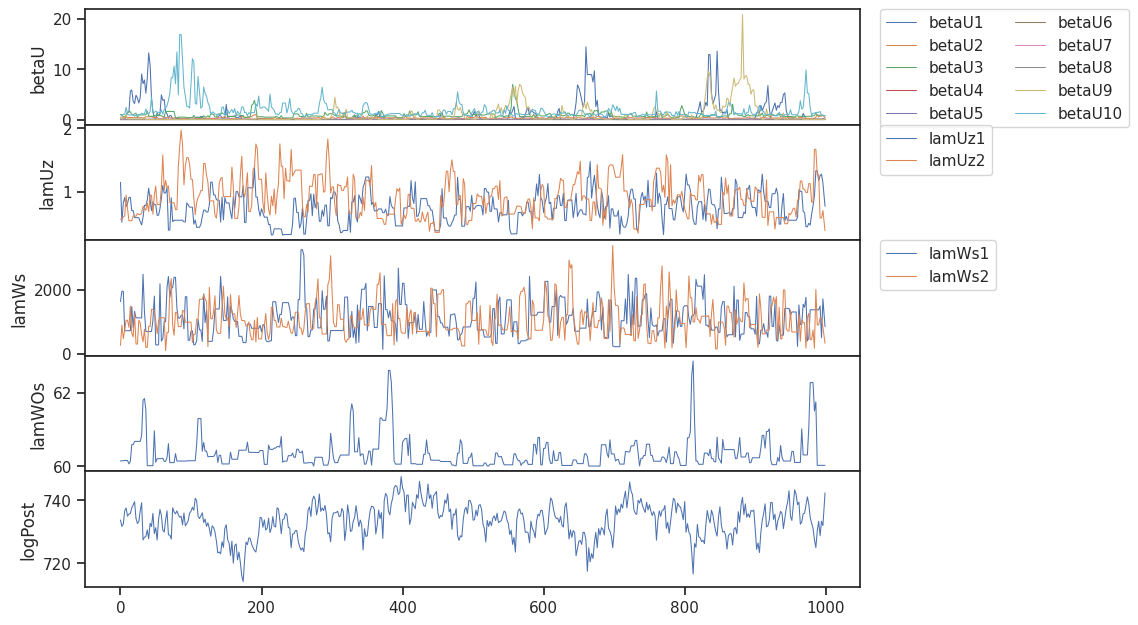

In [21]:
## Data prep
z_index = 0

plt_strings = plot_strings('GSMF')
mlim1, mlim2 = mass_conds('GSMF')
mass_cond = np.where( (stellar_mass > mlim1)  &  (stellar_mass < mlim2) ) 
# mass_cond = True

p_all = params32
y_vals =  10**gsmf_arr_extra[:, mass_cond][:, 0, :]
# y_vals =  gsmf_arr_extra[:, mass_cond][:, 0, :]

y_ind = stellar_mass[mass_cond]#[0]

# y_vals1 =  np.log10(bhmsm_arr_extra[:, mass_cond1][:, 0, :])
# y_ind1 = 10**log_bhmsm_mass[mass_cond1]

print(y_vals.min(), y_vals.max())

#################################################################

# Train-test split
test_indices = [3, 14, 35]

input_params= p_all[test_indices] # p_all[test_indices]
target_vals = y_vals[test_indices] # Bk_all[:, z_index, :][test_indices]

train_indices = [i for i in  np.arange(num_sims) if i not in test_indices] 
p_all_train = p_all[train_indices]
y_vals_train = y_vals[train_indices]

#################################################################

## Fitting
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind)
print(sepia_data)
model_filename = '../models/GSMF_multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=exp_variance)
sepia_model = do_gp_train(sepia_model, model_filename)
sepia_model = gp_load(sepia_model, model_filename)
plot_train_diagnostics(sepia_model)

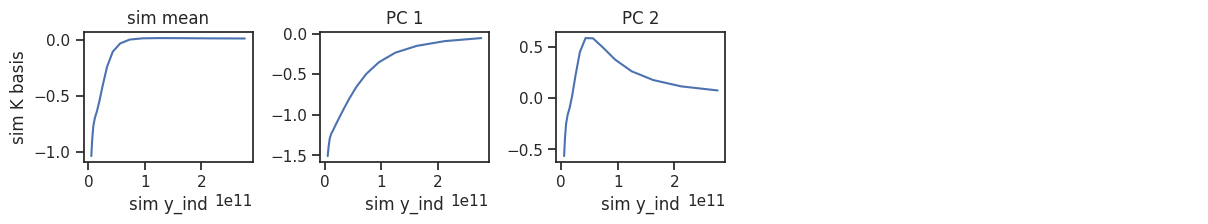

In [22]:
from sepia import SepiaPlot
SepiaPlot.plot_K_basis(sepia_data, max_plots=1);

Maximum relative error (mean): 0.0062 (0.62%)
Mean relative error (mean): 0.0014 (0.14%)
Maximum relative error (quantiles): 0.0092 (0.92%)
Mean relative error (quantiles): 0.0034 (0.34%)
-0.0009396679451810603 0.026036944248802242


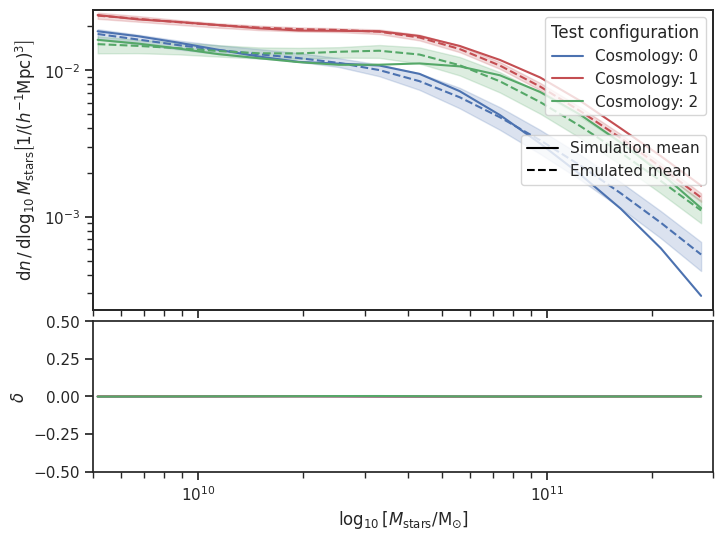

In [23]:
pred_mean, pred_quant = emulate(sepia_model, input_params)
plt_strings = plot_strings('GSMF')
mlim1, mlim2 = mass_conds('GSMF')
mass_cond = np.where( (stellar_mass > mlim1)  &  (stellar_mass < mlim2) ) 

validation_plot( y_ind, np.log10(target_vals), np.log10(pred_mean), np.log10(pred_quant), *plt_strings, mlim1, mlim2, 'log', 'log');
plt.savefig('../plots/GSMF_valid.png', bbox_inches='tight')

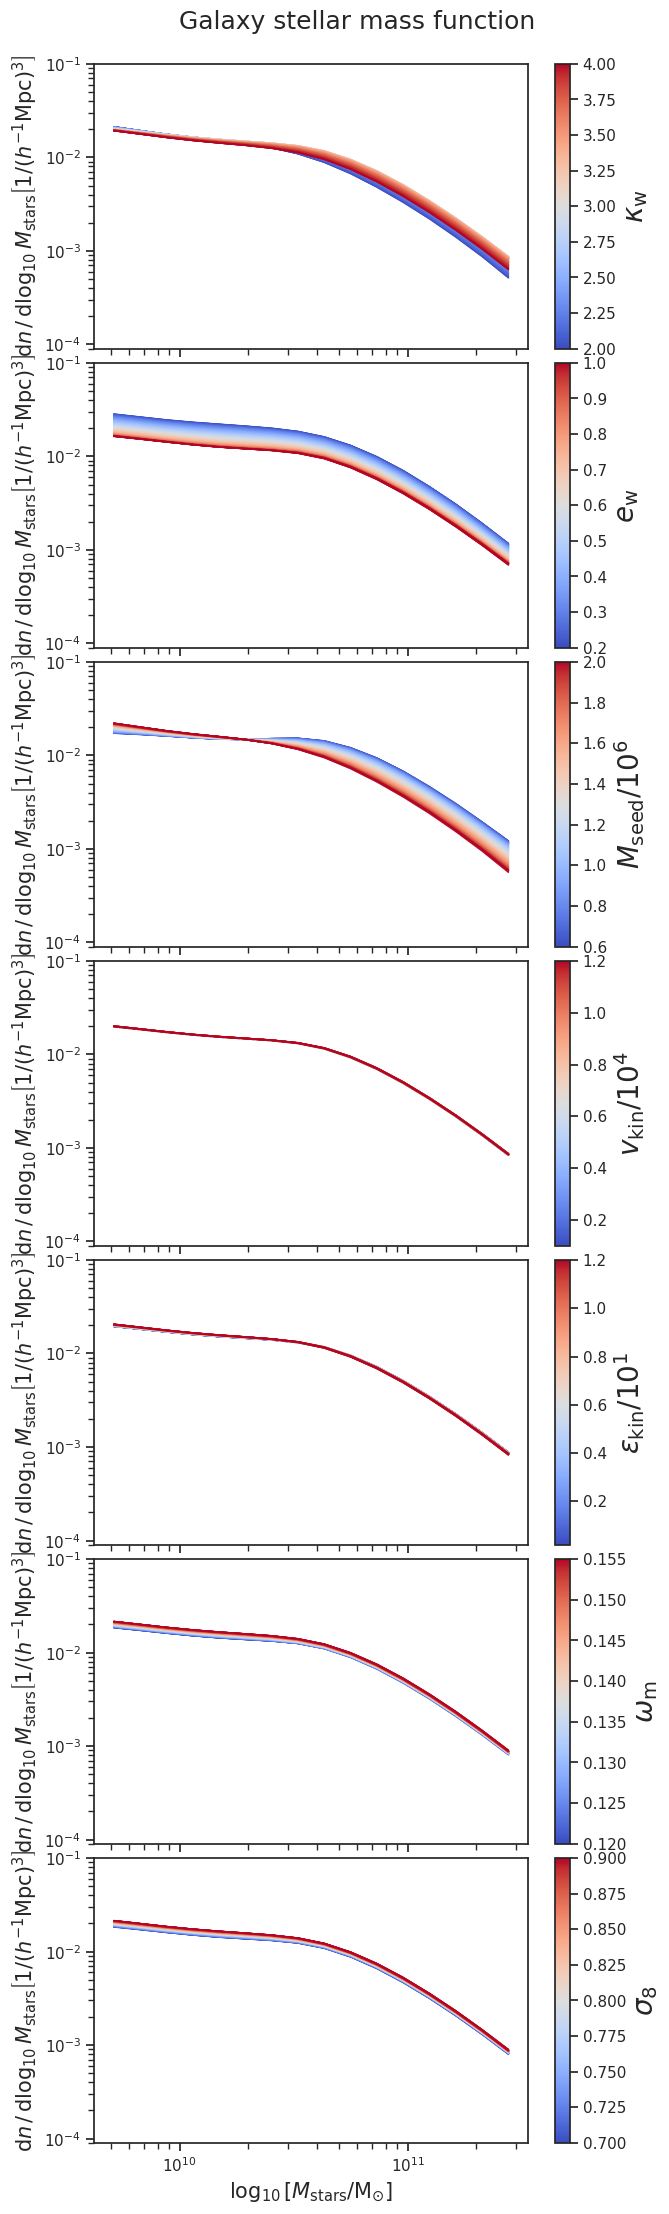

In [24]:
if if_plot_sensi:
    f = sensitivity_plot_gsmf( y_ind, p_all, sepia_model, emulate, PARAM_NAME, *plt_strings, mlim1, mlim2, 'log', 'log')
    plt.savefig('../plots/GSMF_sensi_HACC5p.png', bbox_inches='tight')

# Emulate stat-2: BHMSM -- N/A for now

# Emulate stat-3: fGas

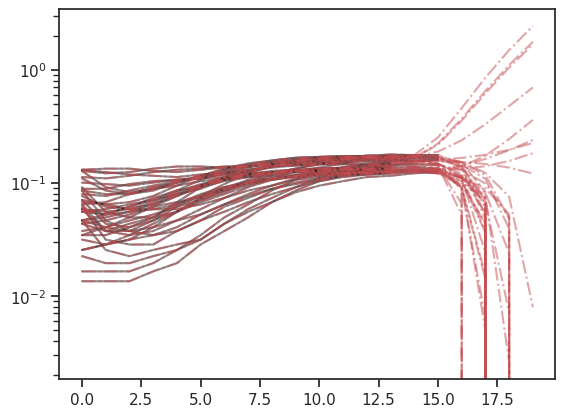

In [25]:
# Example usage with the original data
gas_fr_arr_extra = fill_nan_with_interpolation(gas_fr_arr, 'cubic')

plt.plot(gas_fr_arr.T, 'k', alpha=0.5);
plt.plot(gas_fr_arr_extra.T, 'r-.', alpha=0.5);
plt.yscale('log')

1.0001004073523152 1.0883330805014453
This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 3
m  =    36 (number of simulated data)
p  =     1 (number of inputs)
q  =     7 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|██████████| 50/50 [00:04<00:00, 10.95it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.25977001]
 [0.11177452]
 [0.07519185]
 [0.0199031 ]
 [0.51996913]
 [0.86496682]
 [0.3805226 ]
 [0.23167731]]
lamUz
[[1.39269759]]
lamWs
[[4716.53460593]]
lamWOs
[[9.42264585]]


MCMC sampling: 100%|██████████| 1000/1000 [00:04<00:00, 232.53it/s]


Model saved to ../models/fGas_multivariate_model_z_index0.pkl
No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

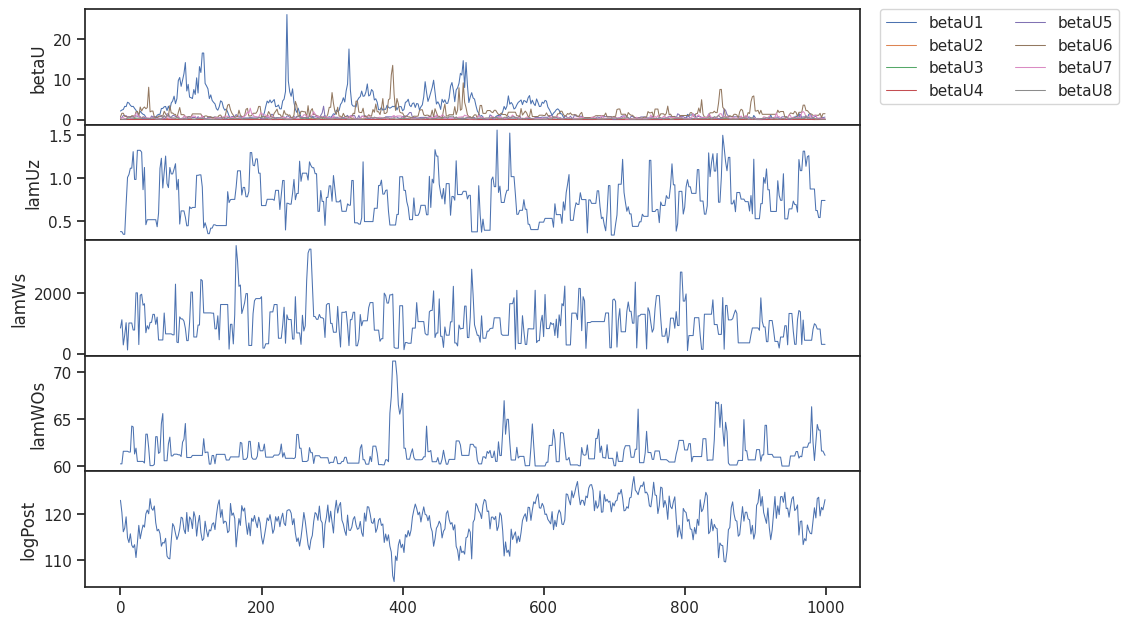

In [26]:
## Data prep
z_index = 0

plt_strings = plot_strings('fGas')
mlim1, mlim2 = mass_conds('fGas')

mass_cond2 = np.where( (10**log_halo_mass > mlim1)  &  (10**log_halo_mass < mlim2) )
# mass_cond2 = True

p_all = params32
y_vals2 =  gas_fr_arr_extra[:, mass_cond2][:, 0, :]
y_ind2 = 10**log_halo_mass[mass_cond2]#[0]

print(y_vals.min(), y_vals.max())

#################################################################

# Train-test split
input_params= p_all[test_indices] # p_all[test_indices]
target_vals = y_vals2[test_indices] # Bk_all[:, z_index, :][test_indices]

train_indices = [i for i in  np.arange(num_sims) if i not in test_indices] 
p_all_train = p_all[train_indices]
y_vals_train = y_vals2[train_indices]

#################################################################

## Fitting
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind2)
print(sepia_data)
model_filename = '../models/fGas_multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=exp_variance)
sepia_model = do_gp_train(sepia_model, model_filename)
sepia_model = gp_load(sepia_model, model_filename)
plot_train_diagnostics(sepia_model)

Maximum relative error (mean): 0.1513 (15.13%)
Mean relative error (mean): 0.0510 (5.10%)
Maximum relative error (quantiles): 0.2439 (24.39%)
Mean relative error (quantiles): 0.1333 (13.33%)
0.09314022168612177 0.17518252151256627


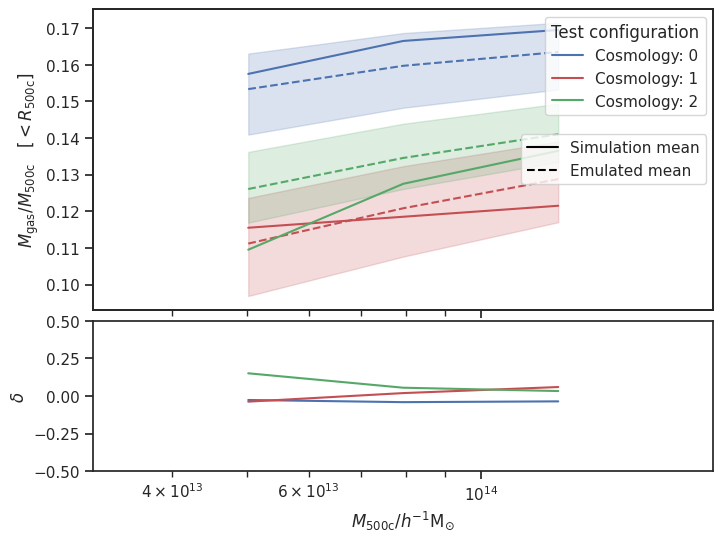

In [27]:
pred_mean, pred_quant = emulate(sepia_model, input_params)
plt_strings = plot_strings('fGas')
mlim1, mlim2 = mass_conds('fGas')
mass_cond2 = np.where( (10**log_halo_mass > mlim1)  &  (10**log_halo_mass < mlim2) )

validation_plot(y_ind2, target_vals, pred_mean, pred_quant, *plt_strings, mlim1, mlim2, 'log', 'linear');
plt.savefig('../plots/fGas_valid.png', bbox_inches='tight')

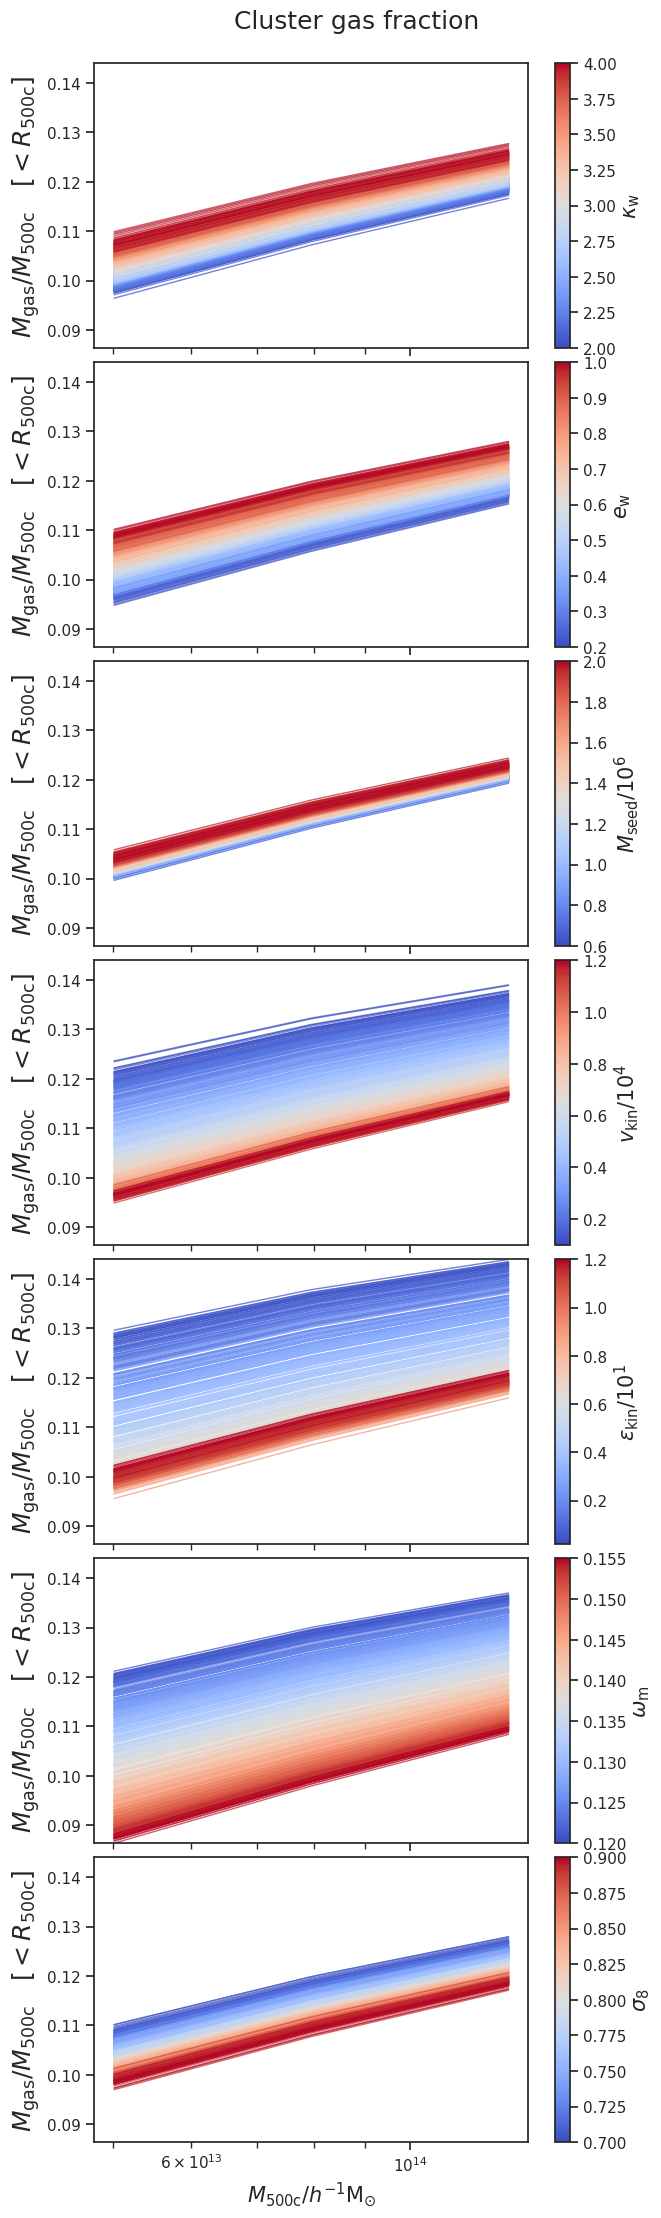

In [28]:
if if_plot_sensi:
    f = sensitivity_plot(y_ind2, p_all, sepia_model, emulate, PARAM_NAME, *plt_strings, mlim1, mlim2, 'log', 'linear')
    plt.savefig('../plots/fGas_sensi_HACC5p.png', bbox_inches='tight')

# Emulate stat-3: CGD

1.0001004073523152 1.0883330805014453
This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 19
m  =    36 (number of simulated data)
p  =     1 (number of inputs)
q  =     7 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|██████████| 50/50 [00:04<00:00, 12.07it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.38937031]
 [0.16671983]
 [0.08318587]
 [0.09856901]
 [0.49660241]
 [1.90933473]
 [0.01742909]
 [0.2843136 ]]
lamUz
[[1.66508316]]
lamWs
[[4680.92827799]]
lamWOs
[[2.23401962]]


MCMC sampling: 100%|██████████| 1000/1000 [00:03<00:00, 267.75it/s]


Model saved to ../models/CGD_multivariate_model_z_index0.pkl
No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

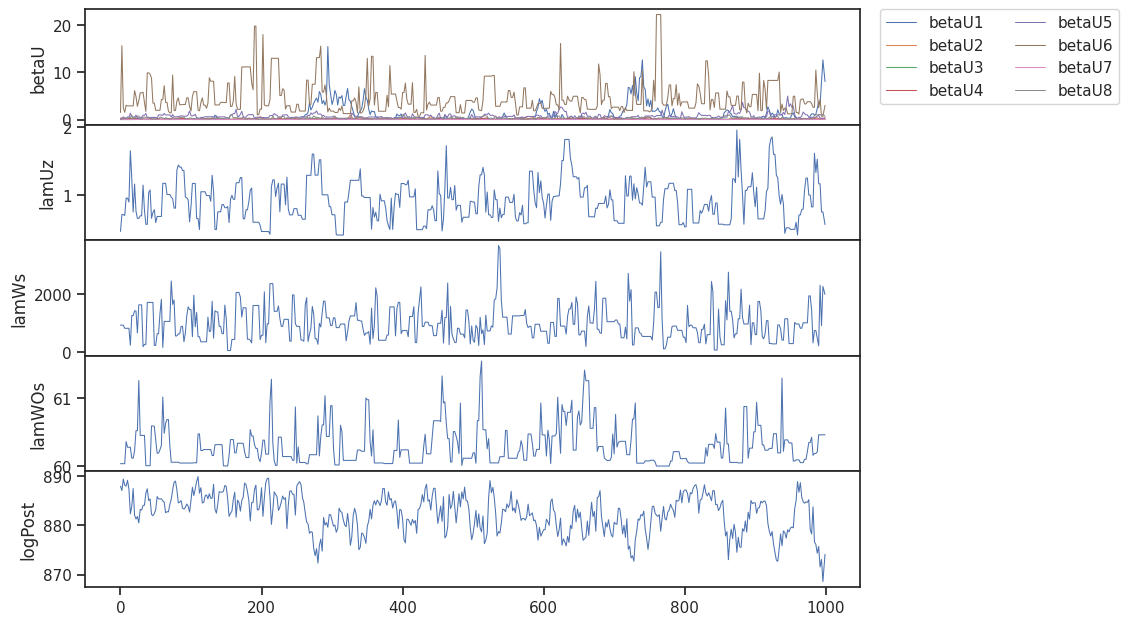

In [29]:
## Data prep
z_index = 0

plt_strings = plot_strings('CGD')
rlim1, rlim2 = mass_conds('CGD')
rad_cond = np.where( (radius > rlim1)  &  (radius < rlim2) ) 
# mass_cond = True

p_all = params32
y_vals3 =  cgd_arr[:, rad_cond][:, 0, :]
y_ind3 = radius[rad_cond]

# y_vals1 =  np.log10(bhmsm_arr_extra[:, mass_cond1][:, 0, :])
# y_ind1 = 10**log_bhmsm_mass[mass_cond1]

print(y_vals.min(), y_vals.max())


#################################################################


input_params= p_all[test_indices] # p_all[test_indices]
target_vals = y_vals3[test_indices] # Bk_all[:, z_index, :][test_indices]

train_indices = [i for i in  np.arange(num_sims) if i not in test_indices] 
p_all_train = p_all[train_indices]
y_vals_train = y_vals3[train_indices]

#################################################################

## Fitting
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind3)
print(sepia_data)
model_filename = '../models/CGD_multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=exp_variance)
sepia_model = do_gp_train(sepia_model, model_filename)
sepia_model = gp_load(sepia_model, model_filename)
plot_train_diagnostics(sepia_model)

Maximum relative error (mean): 0.4619 (46.19%)
Mean relative error (mean): 0.1728 (17.28%)
Maximum relative error (quantiles): 0.7384 (73.84%)
Mean relative error (quantiles): 0.2423 (24.23%)
-333.29155165905087 7019.7739254400685
[0.01539927 0.02053525 0.0273842  0.03651741 0.04869675 0.06493816
 0.08659643 0.1154782  0.15399265 0.2053525  0.27384196 0.36517413
 0.48696753 0.64938163 0.86596432 1.15478198 1.53992653 2.05352503
 2.73841963]


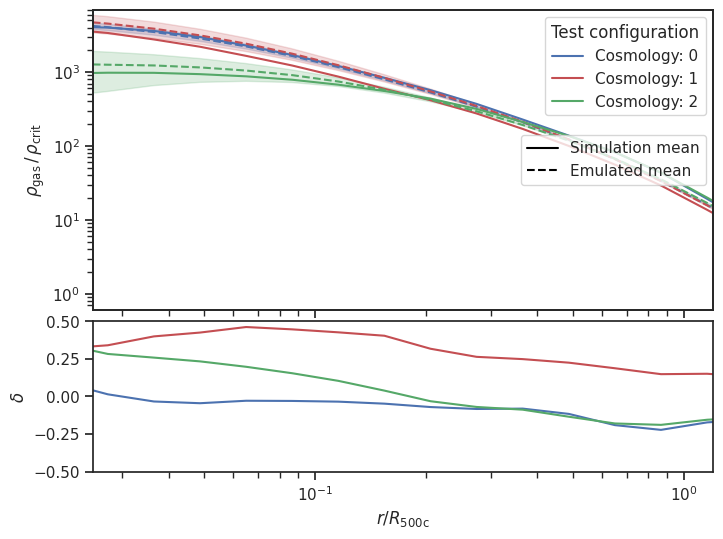

In [30]:
pred_mean, pred_quant = emulate(sepia_model, input_params)
plt_strings = plot_strings('CGD')

validation_plot(y_ind3, target_vals, pred_mean, pred_quant, *plt_strings, None, None, 'log', 'log', (0.05, 1.2));
plt.xlim(0.025, 1.2)
print(y_ind3)

plt.savefig('../plots/CGD_valid.png', bbox_inches='tight')


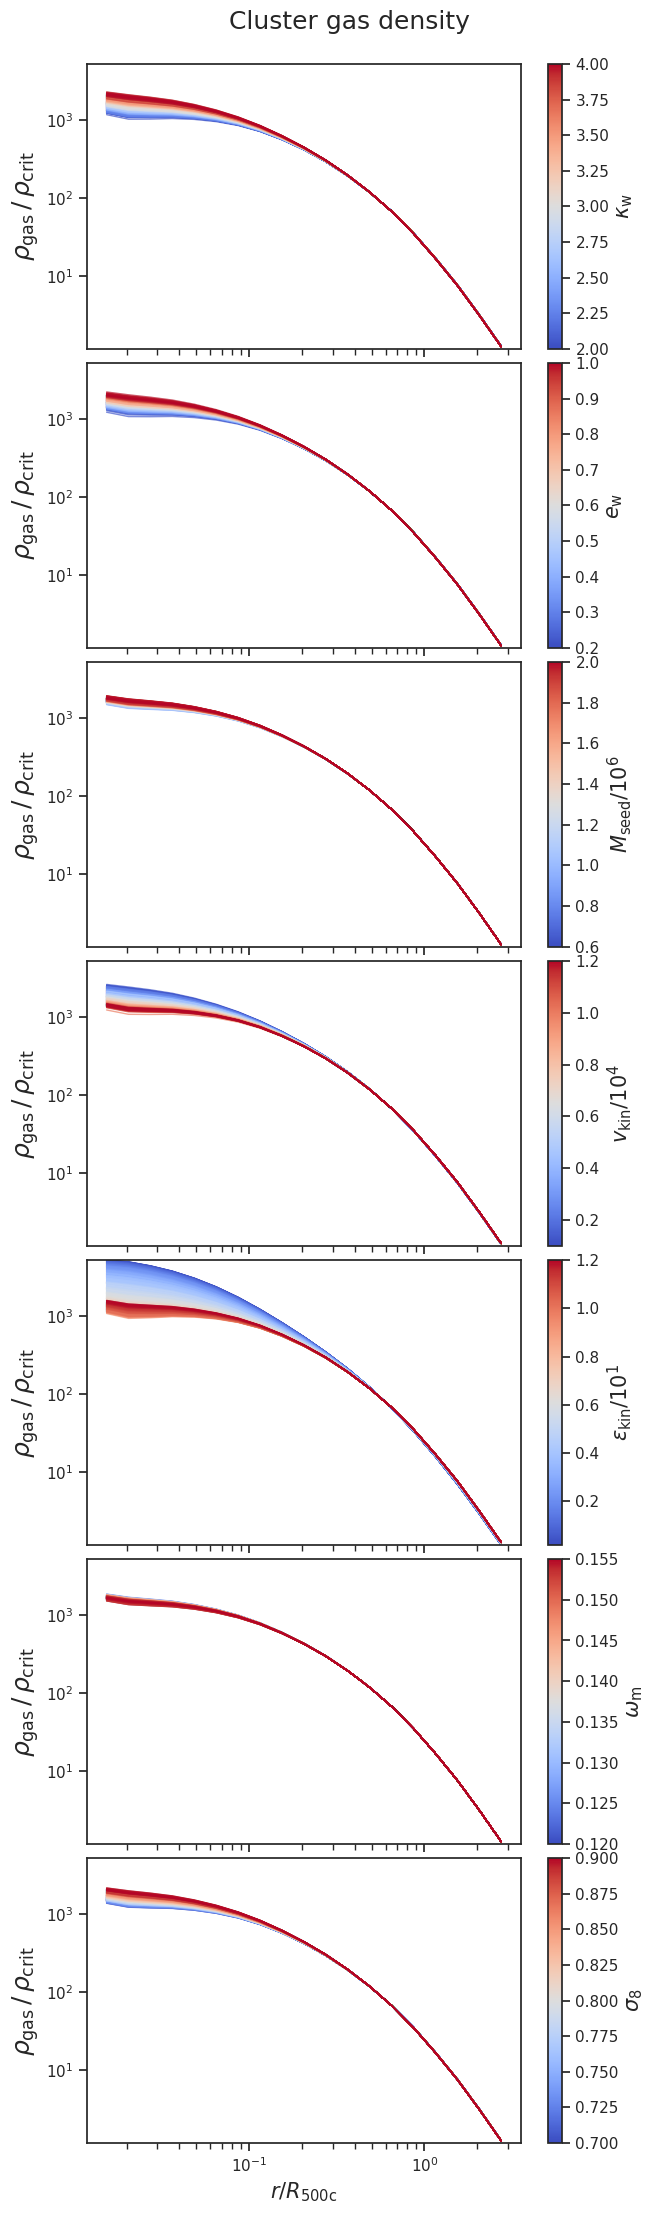

In [31]:
if if_plot_sensi:
    f = sensitivity_plot(y_ind3, p_all, sepia_model, emulate, PARAM_NAME, *plt_strings, None, None, 'log', 'log')
    plt.savefig('../plots/CGD_sensi_HACC5p.png', bbox_inches='tight')


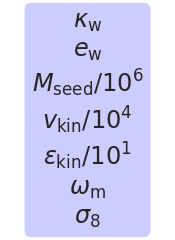

In [32]:
import matplotlib.pyplot as plt

f, a = plt.subplots(1, 1, figsize=(2, 2))
a.set_axis_off()
props = dict(boxstyle='round', facecolor='blue', alpha=0.2)
plt.text(0.5, 0.5, '\n'.join(PARAM_NAME), transform=a.transAxes, fontsize='x-large', bbox=props, ha='center', va='center')
plt.show()